# Who said that, Bolsonaro or Lula? Predicting which Brazilian president tweeted what using Machine Learning techniques.

In [29]:
import tweepy
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
import helper_functions
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

Acessing Twitter's API to fetch tweets from the presidential candidates.

In [2]:
# Creating api client with twitter-api token
MY_BEARER_TOKEN = # your token
client = tweepy.Client(bearer_token=MY_BEARER_TOKEN)

SyntaxError: invalid syntax (2315339984.py, line 2)

In [ ]:
# getting the twitter ids from the twitter handles
bolsonaro_info = client.get_user(username="jairbolsonaro")
lula_info = client.get_user(username="LulaOficial")

Because of the Twitter API's limit on how many tweets we can fetch at once (100), we have to use pagination to fetch more than that.

Important: only execute this cell if you want to access the API. Keep in mind that the API has a cap on how many tweets you can fetch per month (500,000). Otherwise, download the csv and read it in the next cell.

In [ ]:
# fetching the latest 50 tweets from their feed
paginator_bolsonaro = tweepy.Paginator(
    client.get_users_tweets,
    bolsonaro_info.data.id,
    exclude=['retweets', 'replies'],
    max_results=100
)

bolsonaro_tweets = [{'candidato':'bolsonaro', 'tweet':tweet.text} for tweet in paginator_bolsonaro.flatten(limit=1000)]


paginator_lula = tweepy.Paginator(
    client.get_users_tweets,
    lula_info.data.id,
    exclude=['retweets', 'replies'],
    max_results=100
)
lula_tweets = [{'candidato':'lula', 'tweet':tweet.text} for tweet in paginator_lula.flatten(limit=1000)]

# creating a dict of tweets to save them
all_tweets = bolsonaro_tweets + lula_tweets

# saving the tweets to a csv file
with open('tweets.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['candidato', 'tweet'])
    writer.writeheader()
    writer.writerows(all_tweets)

Reading the csv as a Pandas dataframe

In [3]:
tweets_df = pd.read_csv('tweets.csv')
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda tweet: re.sub(r' https://t.co/\w{10}', '', tweet)) # Removing twitter links
tweets_df.head()

,candidato,tweet
0,bolsonaro,"…, intensificar o acompanhamento remoto de pac..."
1,bolsonaro,- A telemedicina aparece como alternativa para...
2,bolsonaro,- Em dezembro de 2022 sancionamos o Projeto de...
3,bolsonaro,"- Além disso, a nova tarifa reflete a redução ..."
4,bolsonaro,- As reduções representam uma redução de mais ...


### 1) Creating a word cloud for both candidates to see if there are any correlations in their vocabulary just from looking at it

In [4]:
# Loading a list of portuguese stop words, since sklearn only has english words by default
with open('portuguese_stop_words.txt', 'r') as file:
    content = file.read()
    stop_words = re.split(" \n|\n", content)

Bolsonaro's word cloud

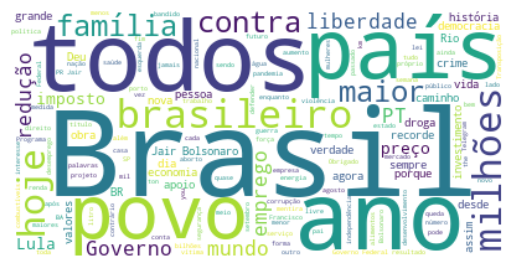

In [5]:
bolsonaro_text = " ".join(tweet for tweet in tweets_df.loc[tweets_df['candidato'] == 'bolsonaro']['tweet'])

wordcloud = WordCloud(stopwords=stop_words, max_words=200, background_color='white', contour_width=3, contour_color='steelblue').generate(bolsonaro_text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('imgs/bolsonaro_word_cloud.png')

Lula's word cloud

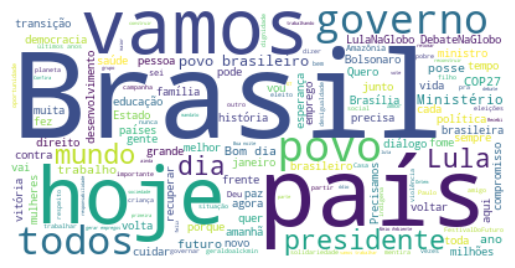

In [6]:
lula_text = " ".join(tweet for tweet in tweets_df.loc[tweets_df['candidato'] == 'lula']['tweet'])
#map_mask = np.array(Image.open('imgs/brazil-map.png'))

wordcloud = WordCloud(stopwords=stop_words, max_words=200, background_color='white', contour_width=3, contour_color='steelblue').generate(lula_text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('imgs/lula_word_cloud.png')

### 2) Training the dataset using Multinomial Naive-Bayes

Train and test split

In [7]:
y = tweets_df['candidato']
X = tweets_df['tweet']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=7)

Vectorizing the tweets using TF-IDF.

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=0.03, max_df=0.99)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [9]:
tfidf_vectorizer.vocabulary_

{'bolsonaro': 3,
 'hoje': 19,
 'presidente': 30,
 'brasil': 5,
 'posse': 28,
 'anos': 2,
 'governo': 16,
 'brasileiro': 6,
 'país': 25,
 'empregos': 13,
 'ministério': 23,
 'pessoas': 26,
 'vida': 36,
 'saúde': 31,
 'contra': 8,
 'agora': 1,
 'milhões': 22,
 'brasileiros': 7,
 '2022': 0,
 'vamos': 34,
 'grande': 17,
 'deus': 11,
 'todos': 32,
 'lula': 20,
 'povo': 29,
 'democracia': 10,
 'bom': 4,
 'dia': 12,
 'futuro': 15,
 'vez': 35,
 'cop27': 9,
 'mundo': 24,
 'maior': 21,
 'história': 18,
 'trabalho': 33,
 'porque': 27,
 'federal': 14}

Treinando o modelo utilizando MultinomialNB

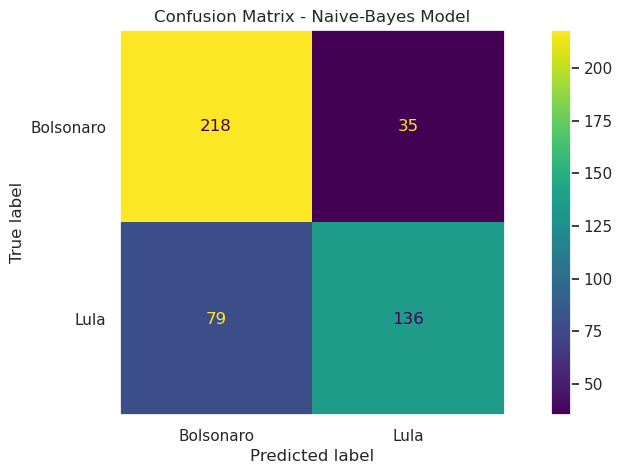

In [23]:
# Creating a Multinomial model
model_nb = MultinomialNB()

# Training the model
model_nb.fit(tfidf_train, y_train)

# Predicting the test set
nb_pred = model_nb.predict(tfidf_test)

# Calculating accuracy score
nb_score = metrics.accuracy_score(y_test, nb_pred)

# Evaluating the model with a confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, nb_pred, display_labels=['Bolsonaro', 'Lula'])
plt.title('Confusion Matrix - Naive-Bayes Model')
plt.grid(False)
plt.savefig('imgs/nb_confusion_matrix.png', format='png')
plt.show()

In [13]:
nb_score

0.7564102564102564

In [ ]:
import imp
imp.reload(helper_functions)

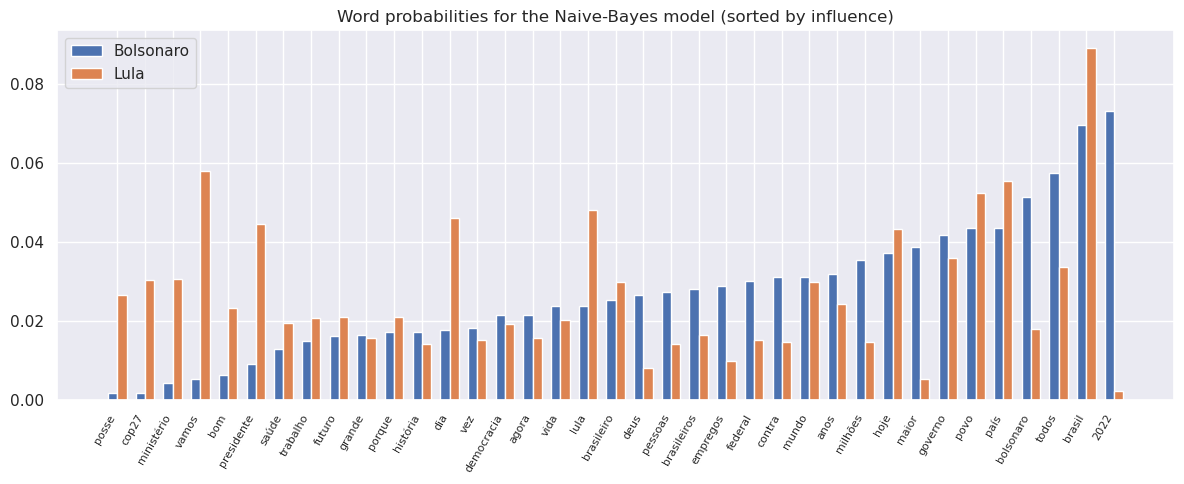

<Figure size 1200x500 with 0 Axes>

In [30]:
plt.rcParams['figure.figsize'] = [12, 5]
helper_functions.plot_top_words(model_nb, tfidf_vectorizer, title='imgs/nb_top_words.png')

### TODO
Seems that our model, as predicted, isn't performing very well. Let's take a look at some of the wrong predictions to see if there are any tells right away.

In [17]:
# Saving the results in a data frame so we can analyze it
results_nb = pd.DataFrame(y_test)
results_nb['pred'] = nb_pred
results_nb['tweet'] = X_test

# Selecting only wrong predctions
results_nb.loc[results_nb['candidato'] != results_nb['pred']].to_csv('wrong_predictions.csv')

### 2) LinearSVC model

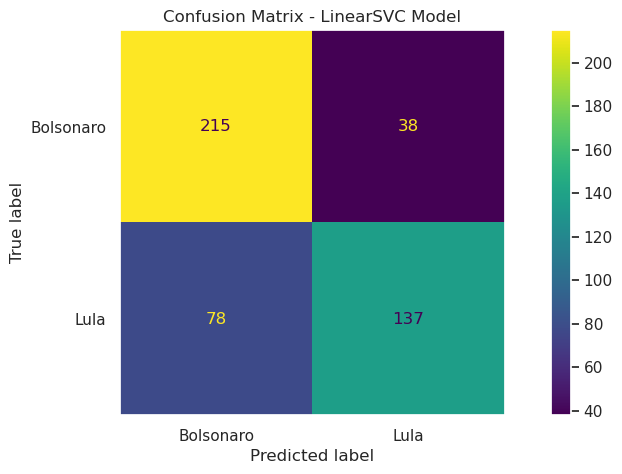

In [25]:
# Creating the model
model_linear = LinearSVC()

# Training the model
model_linear.fit(tfidf_train, y_train)

# Predicting the results
linear_pred = model_linear.predict(tfidf_test)

# Calculating the accuracy score
linear_score = metrics.accuracy_score(y_test, linear_pred)

# Evalutating the model with a confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, linear_pred, display_labels=['Bolsonaro', 'Lula'])
plt.title('Confusion Matrix - LinearSVC Model')
plt.grid(False)
plt.savefig('imgs/linearsvc_confusion_matrix.png', format='png')
plt.show()

In [45]:
linear_score

0.7521367521367521

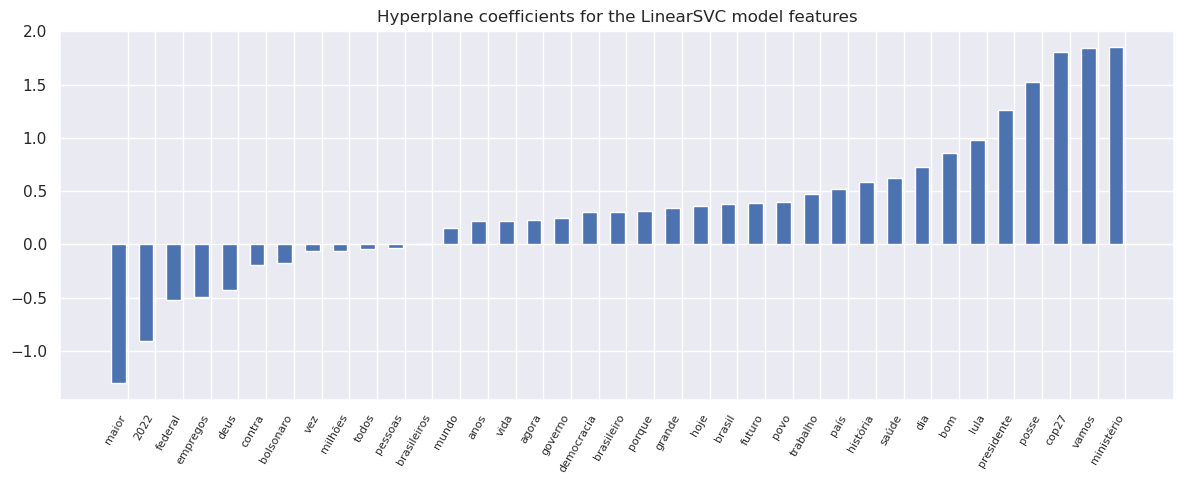

<Figure size 1200x500 with 0 Axes>

In [26]:
helper_functions.plot_top_words(model_linear, tfidf_vectorizer, title='imgs/linearsvc_top_words.png')

### 3) Random Forest model

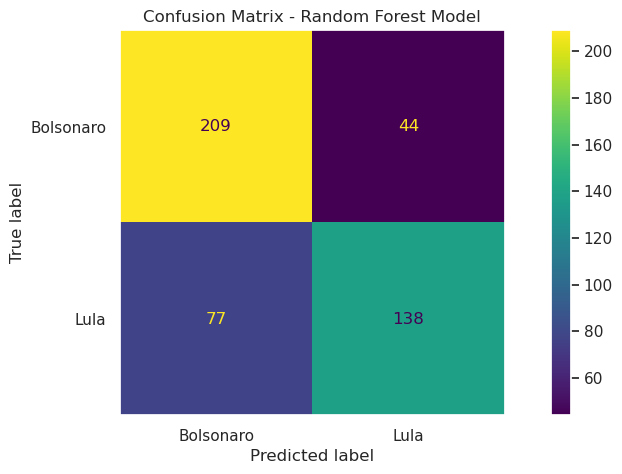

In [27]:
# Creating the model
model_rf = RandomForestClassifier()

# Training the model
model_rf.fit(tfidf_train, y_train)

# Predicting the results
rf_pred = model_rf.predict(tfidf_test)

# Calculating the accuracy score
rf_score = metrics.accuracy_score(y_test, linear_pred)

# Evalutating the model with a confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, display_labels=['Bolsonaro', 'Lula'])
plt.title('Confusion Matrix - Random Forest Model')
plt.grid(False)
plt.savefig('imgs/rf_confusion_matrix.png', format='png')
plt.show()

In [52]:
rf_score

0.7521367521367521

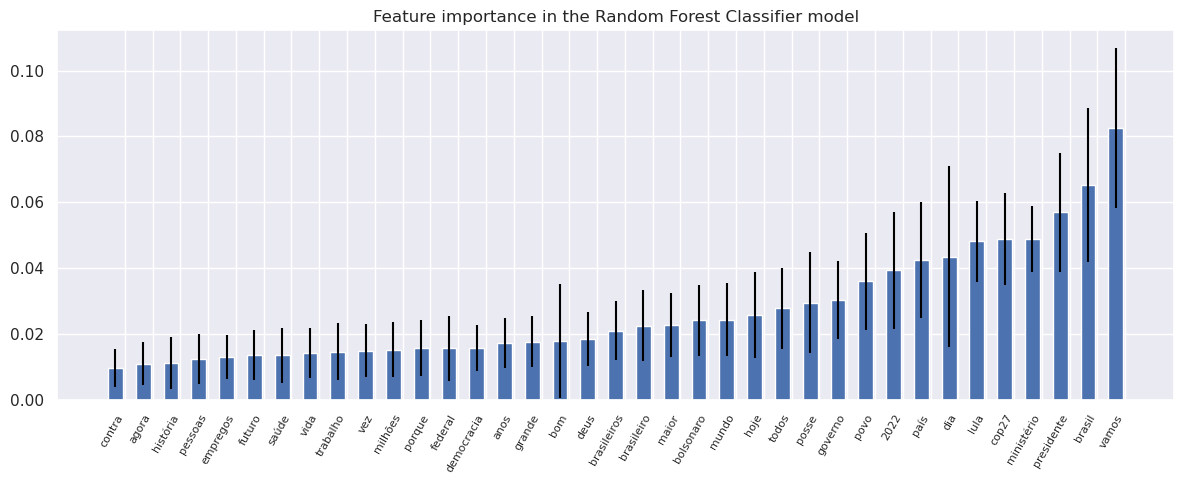

<Figure size 1200x500 with 0 Axes>

In [28]:
helper_functions.plot_top_words(model_rf, tfidf_vectorizer, title='imgs/rf_top_words.png')